# Session 7: Long-Horizon Event Studies

## Event Studies in Finance and Economics - Summer School

---

### Learning Objectives

By the end of this session, you will be able to:

1. Understand the challenges unique to long-horizon event studies
2. Implement Buy-and-Hold Abnormal Returns (BHAR)
3. Apply the Calendar-Time Portfolio approach
4. Handle overlapping events and cross-correlation
5. Choose appropriate benchmarks for long-horizon studies
6. Recognize power limitations and interpret results cautiously

---

## 1. Introduction: Why Long-Horizon Studies?

### Short-Horizon vs Long-Horizon

| Aspect | Short-Horizon (3-5 days) | Long-Horizon (6-36 months) |
|--------|--------------------------|----------------------------|
| **Question** | Immediate market reaction | Long-term value creation |
| **Assumption** | Market efficiency | Possible mispricing |
| **Challenges** | Relatively few | Many (compounding, benchmark, power) |
| **Examples** | Earnings, M&A announcement | Post-IPO, post-merger performance |

### Research Questions

- Do IPO firms underperform in the long run?
- Is there post-merger drift?
- Do stock splits predict future returns?
- Is the initial market reaction correct?

### Key Challenges

1. **Compounding**: Small daily biases compound to large errors
2. **Benchmark selection**: Expected returns hard to estimate
3. **Cross-correlation**: Events cluster in time
4. **Survivorship bias**: Firms may delist
5. **Low power**: Hard to detect true effects

## 2. Setup and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import yfinance as yf
import statsmodels.api as sm
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from dataclasses import dataclass
from typing import List, Dict, Optional, Tuple
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
print("Libraries loaded!")

Libraries loaded!


In [2]:
# Sample: Tech IPOs from 2020-2021 for long-horizon analysis
# We'll examine 12-month post-IPO performance
IPOS = [
    {'ticker': 'ABNB', 'date': '2020-12-10', 'name': 'Airbnb'},
    {'ticker': 'DASH', 'date': '2020-12-09', 'name': 'DoorDash'},
    {'ticker': 'SNOW', 'date': '2020-09-16', 'name': 'Snowflake'},
    {'ticker': 'PLTR', 'date': '2020-09-30', 'name': 'Palantir'},
    {'ticker': 'RBLX', 'date': '2021-03-10', 'name': 'Roblox'},
    {'ticker': 'COIN', 'date': '2021-04-14', 'name': 'Coinbase'},
    {'ticker': 'PATH', 'date': '2021-04-21', 'name': 'UiPath'},
    {'ticker': 'DUOL', 'date': '2021-07-28', 'name': 'Duolingo'},
    {'ticker': 'HOOD', 'date': '2021-07-29', 'name': 'Robinhood'},
    {'ticker': 'RIVN', 'date': '2021-11-10', 'name': 'Rivian'},
]

# Long-horizon parameters
HORIZON_MONTHS = 12  # 1-year post-event
ESTIMATION_DAYS = 0  # No pre-event estimation for IPOs

print(f"Sample: {len(IPOS)} tech IPOs from 2020-2021")
print(f"Horizon: {HORIZON_MONTHS} months post-IPO")

Sample: 10 tech IPOs from 2020-2021
Horizon: 12 months post-IPO


In [3]:
@dataclass
class LongHorizonResult:
    """Container for long-horizon event study results."""
    ticker: str
    name: str
    ipo_date: pd.Timestamp
    end_date: pd.Timestamp
    trading_days: int
    data: pd.DataFrame
    buy_hold_return: float
    market_return: float
    bhar: float


def download_long_horizon_data(ticker: str, event_date: str, name: str,
                                horizon_months: int) -> Optional[LongHorizonResult]:
    """Download data for long-horizon event study."""
    try:
        event_dt = pd.to_datetime(event_date)
        # Add buffer for data availability
        start_date = event_dt - timedelta(days=5)
        end_date = event_dt + relativedelta(months=horizon_months) + timedelta(days=30)
        
        # Download stock and market data
        stock = yf.download(ticker, start=start_date, end=end_date, progress=False)['Close']
        market = yf.download('^GSPC', start=start_date, end=end_date, progress=False)['Close']
        
        # Create DataFrame
        df = pd.DataFrame({
            'stock_price': stock.squeeze(),
            'market_price': market.squeeze()
        }).dropna()
        
        # Calculate returns
        df['stock_ret'] = df['stock_price'].pct_change()
        df['market_ret'] = df['market_price'].pct_change()
        
        # Find actual IPO date in data (first trading day)
        if event_dt not in df.index:
            idx = df.index.get_indexer([event_dt], method='bfill')[0]
            if idx < 0 or idx >= len(df):
                return None
            event_dt = df.index[idx]
        
        # Get horizon end date
        target_end = event_dt + relativedelta(months=horizon_months)
        mask = (df.index >= event_dt) & (df.index <= target_end)
        horizon_data = df[mask].copy()
        
        if len(horizon_data) < 20:
            return None
        
        # Calculate event time (trading days)
        horizon_data['event_day'] = range(len(horizon_data))
        
        # Calculate cumulative returns
        horizon_data['cum_stock_ret'] = (1 + horizon_data['stock_ret']).cumprod() - 1
        horizon_data['cum_market_ret'] = (1 + horizon_data['market_ret']).cumprod() - 1
        
        # Buy-and-hold returns
        bhr_stock = horizon_data['cum_stock_ret'].iloc[-1]
        bhr_market = horizon_data['cum_market_ret'].iloc[-1]
        bhar = bhr_stock - bhr_market
        
        return LongHorizonResult(
            ticker=ticker,
            name=name,
            ipo_date=event_dt,
            end_date=horizon_data.index[-1],
            trading_days=len(horizon_data),
            data=horizon_data,
            buy_hold_return=bhr_stock,
            market_return=bhr_market,
            bhar=bhar
        )
    except Exception as e:
        print(f"{ticker}: FAILED - {e}")
        return None


print("Downloading long-horizon data...")
ipo_results = [r for ipo in IPOS if (r := download_long_horizon_data(
    ipo['ticker'], ipo['date'], ipo['name'], HORIZON_MONTHS))]
print(f"Successfully processed {len(ipo_results)} IPOs")

YF.download() has changed argument auto_adjust default to True
Successfully processed 10 IPOs


In [7]:
# Display sample overview
print("\nIPO Sample Overview:")
print("="*80)
print(f"{'Ticker':<8} {'Name':<15} {'IPO Date':<12} {'Days':<6} {'BHR':>10} {'Market':>10} {'BHAR':>10}")
print("-"*80)
for r in ipo_results:
    print(f"{r.ticker:<8} {r.name:<15} {r.ipo_date.strftime('%Y-%m-%d'):<12} {r.trading_days:<6} "
          f"{r.buy_hold_return*100:>+9.1f}% {r.market_return*100:>+9.1f}% {r.bhar*100:>+9.1f}%")
print("-"*80)
avg_bhar = np.mean([r.bhar for r in ipo_results])
print(f"{'Average':<8} {'':<15} {'':<12} {'':<6} {'':<10} {'':<10} {avg_bhar*100:>+9.1f}%")


IPO Sample Overview:
Ticker   Name            IPO Date     Days          BHR     Market       BHAR
--------------------------------------------------------------------------------
ABNB     Airbnb          2020-12-10   253        +24.7%     +28.5%      -3.8%
DASH     DoorDash        2020-12-09   253        -13.0%     +27.1%     -40.1%
SNOW     Snowflake       2020-09-16   253        +27.4%     +32.1%      -4.7%
PLTR     Palantir        2020-09-30   253       +153.1%     +28.1%    +125.0%
RBLX     Roblox          2021-03-10   254        -40.3%      +9.3%     -49.6%
COIN     Coinbase        2021-04-14   255        -55.1%      +6.5%     -61.6%
PATH     UiPath          2021-04-21   254        -73.9%      +5.3%     -79.1%
DUOL     Duolingo        2021-07-28   253        -29.3%      -7.5%     -21.8%
HOOD     Robinhood       2021-07-29   253        -74.0%      -6.5%     -67.5%
RIVN     Rivian          2021-11-10   253        -67.3%     -14.9%     -52.4%
---------------------------------------

## 3. Buy-and-Hold Abnormal Returns (BHAR)

### Definition

$$BHAR_i(\tau_1, \tau_2) = \prod_{t=\tau_1}^{\tau_2}(1 + R_{i,t}) - \prod_{t=\tau_1}^{\tau_2}(1 + E[R_{i,t}])$$

### Interpretation

BHAR represents the difference between:
- What an investor would earn buying the event stock at $\tau_1$ and holding until $\tau_2$
- What they would earn from the benchmark over the same period

### BHAR vs CAR

| Measure | Formula | Compounding | Bias |
|---------|---------|-------------|------|
| CAR | $\sum AR_t$ | No | Overstates for gains |
| BHAR | $\prod(1+R) - \prod(1+E[R])$ | Yes | Can be skewed |

In [10]:
def calculate_bhar(data: pd.DataFrame, start_day: int, end_day: int) -> Dict:
    """
    Calculate BHAR for a specific window.
    """
    mask = (data['event_day'] >= start_day) & (data['event_day'] <= end_day)
    window_data = data[mask]
    
    if len(window_data) < 2:
        return {'bhr': np.nan, 'benchmark': np.nan, 'bhar': np.nan}
    
    # Buy-and-hold return
    bhr = (1 + window_data['stock_ret']).prod() - 1
    benchmark = (1 + window_data['market_ret']).prod() - 1
    bhar = bhr - benchmark
    
    return {'bhr': bhr, 'benchmark': benchmark, 'bhar': bhar, 'days': len(window_data)}


# Calculate BHAR for different horizons
horizons = [
    (0, 21, '1 month'),
    (0, 63, '3 months'),
    (0, 126, '6 months'),
    (0, 252, '12 months'),
]

print("\nBHAR by Horizon:")
print("="*90)

bhar_results = {}
for start, end, label in horizons:
    bhars = []
    for r in ipo_results:
        result = calculate_bhar(r.data, start, end)
        if not np.isnan(result['bhar']):
            bhars.append(result['bhar'])
    
    if bhars:
        bhars = np.array(bhars)
        bhar_results[label] = bhars
        
        # t-test
        t_stat, p_value = stats.ttest_1samp(bhars, 0)
        sig = '***' if p_value < 0.01 else '**' if p_value < 0.05 else '*' if p_value < 0.10 else ''
        
        print(f"\n{label}:")
        print(f"  N = {len(bhars)}")
        print(f"  Mean BHAR = {np.mean(bhars)*100:+.2f}%")
        print(f"  Median BHAR = {np.median(bhars)*100:+.2f}%")
        print(f"  t-stat = {t_stat:.2f} {sig} (p = {p_value:.4f})")


BHAR by Horizon:

1 month:
  N = 10
  Mean BHAR = +1.98%
  Median BHAR = +2.47%
  t-stat = 0.39  (p = 0.7073)

3 months:
  N = 10
  Mean BHAR = +15.36%
  Median BHAR = +9.53%
  t-stat = 0.87  (p = 0.4092)

6 months:
  N = 10
  Mean BHAR = -16.81%
  Median BHAR = -30.37%
  t-stat = -1.00  (p = 0.3430)

12 months:
  N = 10
  Mean BHAR = -25.14%
  Median BHAR = -42.98%
  t-stat = -1.36  (p = 0.2073)


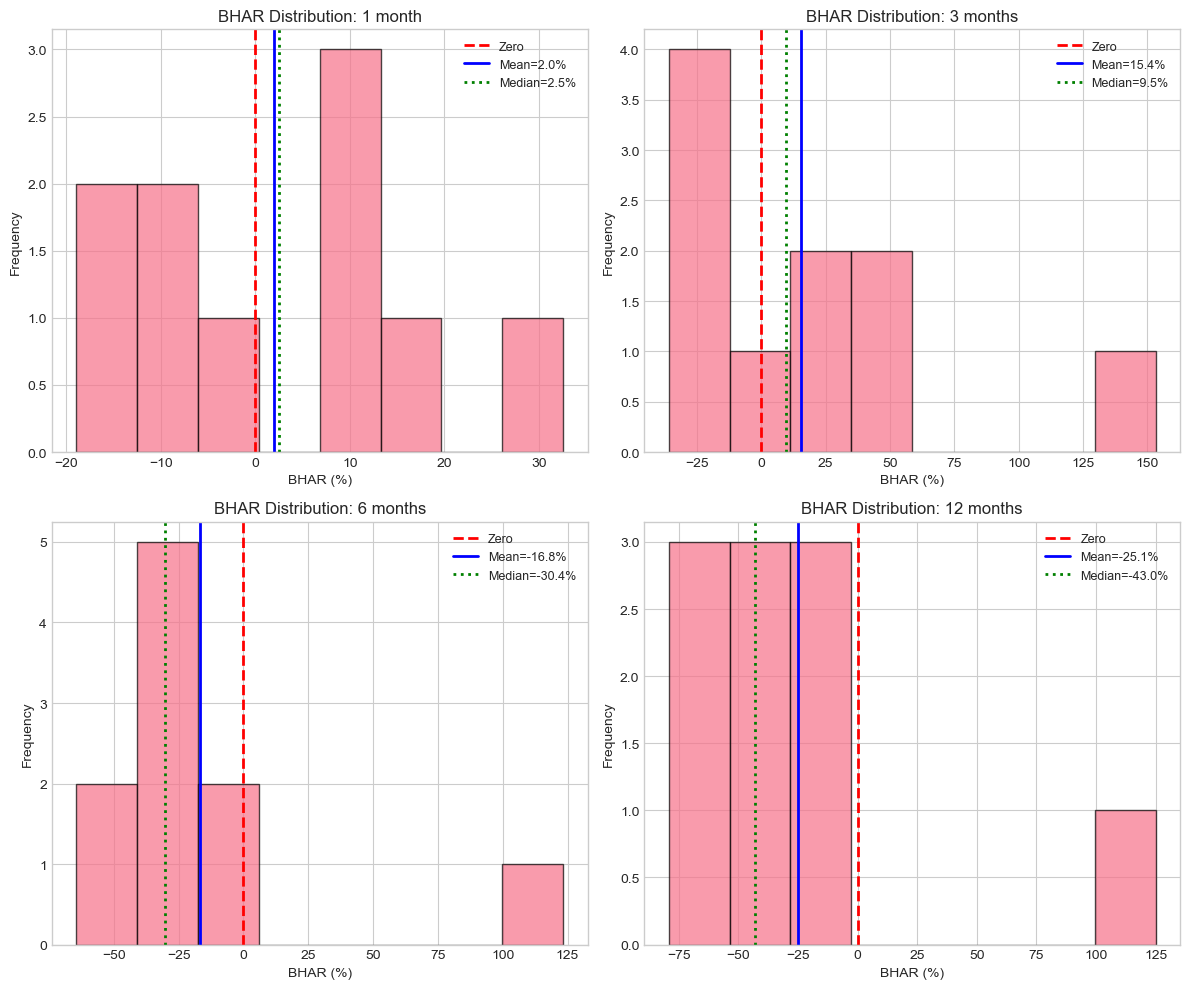

In [12]:
# Visualize BHAR distribution
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, (label, bhars) in enumerate(bhar_results.items()):
    ax = axes.flatten()[i]
    ax.hist(bhars * 100, bins=8, edgecolor='black', alpha=0.7)
    ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero')
    ax.axvline(np.mean(bhars)*100, color='blue', linestyle='-', linewidth=2, 
               label=f'Mean={np.mean(bhars)*100:.1f}%')
    ax.axvline(np.median(bhars)*100, color='green', linestyle=':', linewidth=2,
               label=f'Median={np.median(bhars)*100:.1f}%')
    ax.set_xlabel('BHAR (%)')
    ax.set_ylabel('Frequency')
    ax.set_title(f'BHAR Distribution: {label}')
    ax.legend(fontsize=9)

plt.tight_layout()
plt.show()

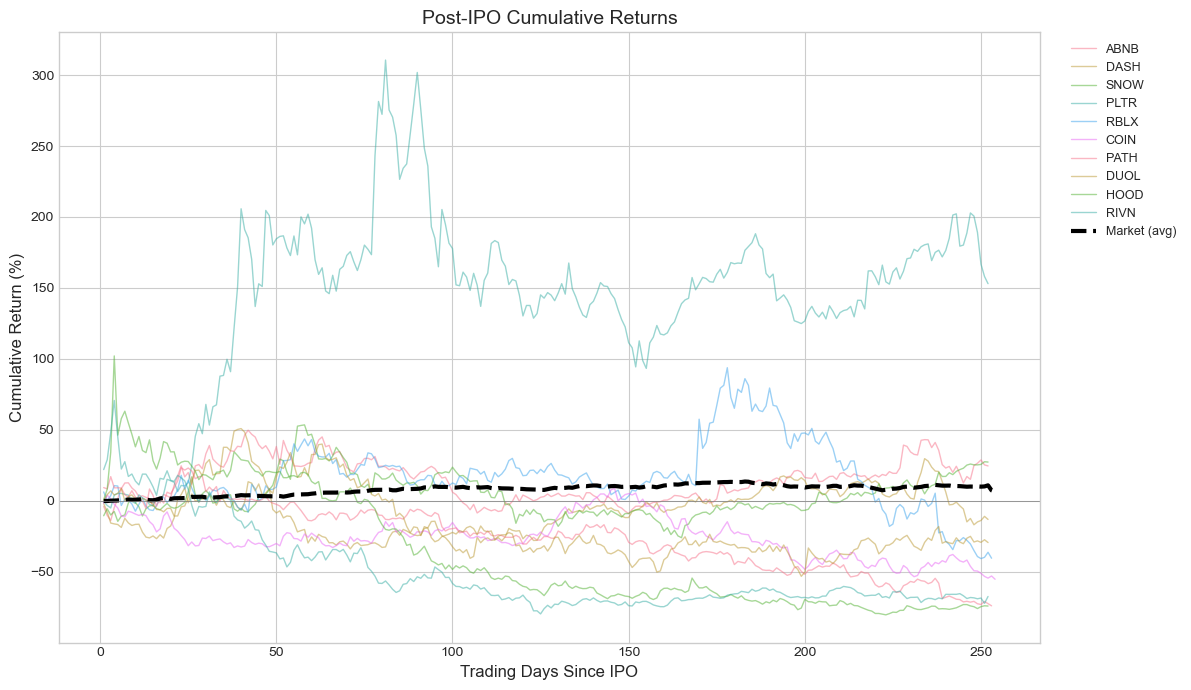

In [13]:
# Plot cumulative returns over time
fig, ax = plt.subplots(figsize=(12, 7))

# Plot each IPO's cumulative return
for r in ipo_results:
    ax.plot(r.data['event_day'], r.data['cum_stock_ret']*100, 
            alpha=0.5, linewidth=1, label=r.ticker)

# Plot average market return
# Align all to same event time
max_days = max(r.trading_days for r in ipo_results)
avg_market = np.zeros(max_days)
count = np.zeros(max_days)

for r in ipo_results:
    days = len(r.data)
    avg_market[:days] += r.data['cum_market_ret'].values
    count[:days] += 1

avg_market = avg_market / np.maximum(count, 1)
ax.plot(range(max_days), avg_market*100, 'k--', linewidth=3, label='Market (avg)')

ax.axhline(0, color='gray', linestyle='-', linewidth=0.5)
ax.set_xlabel('Trading Days Since IPO', fontsize=12)
ax.set_ylabel('Cumulative Return (%)', fontsize=12)
ax.set_title('Post-IPO Cumulative Returns', fontsize=14)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)

plt.tight_layout()
plt.show()

## 4. CAR vs BHAR: The Compounding Problem

### Why It Matters

Over long horizons, the difference between CAR and BHAR can be substantial:

$$CAR = \sum_{t=1}^{T} AR_t \neq BHAR = \prod_{t=1}^{T}(1+R_t) - \prod_{t=1}^{T}(1+E[R_t])$$

### Example

Consider a stock that goes up 10% then down 10%:
- CAR = +10% - 10% = 0%
- BHAR = (1.10)(0.90) - 1 = -1%

In [17]:
def calculate_car_long_horizon(data: pd.DataFrame, start_day: int, end_day: int) -> float:
    """Calculate CAR (sum of abnormal returns) for long horizon."""
    mask = (data['event_day'] >= start_day) & (data['event_day'] <= end_day)
    window_data = data[mask]
    
    ar = window_data['stock_ret'] - window_data['market_ret']
    return ar.sum()


# Compare CAR vs BHAR
print("CAR vs BHAR Comparison:")
print("="*80)
print(f"{'Ticker':<8} {'CAR (12m)':>12} {'BHAR (12m)':>12} {'Difference':>12}")
print("-"*80)

car_bhar_diff = []
for r in ipo_results:
    car = calculate_car_long_horizon(r.data, 0, 252)
    bhar_result = calculate_bhar(r.data, 0, 252)
    bhar = bhar_result['bhar'] if not np.isnan(bhar_result['bhar']) else np.nan
    
    if not np.isnan(bhar):
        diff = car - bhar
        car_bhar_diff.append({'ticker': r.ticker, 'car': car, 'bhar': bhar, 'diff': diff})
        print(f"{r.ticker:<8} {car*100:>+11.2f}% {bhar*100:>+11.2f}% {diff*100:>+11.2f}%")

print("-"*80)
avg_car = np.mean([d['car'] for d in car_bhar_diff])
avg_bhar = np.mean([d['bhar'] for d in car_bhar_diff])
avg_diff = np.mean([d['diff'] for d in car_bhar_diff])
print(f"{'Average':<8} {avg_car*100:>+11.2f}% {avg_bhar*100:>+11.2f}% {avg_diff*100:>+11.2f}%")

print("\nNote: Positive difference means CAR overstates performance.")

CAR vs BHAR Comparison:
Ticker      CAR (12m)   BHAR (12m)   Difference
--------------------------------------------------------------------------------
ABNB          +11.07%       -3.78%      +14.85%
DASH          -16.76%      -40.09%      +23.33%
SNOW          +13.90%       -4.74%      +18.64%
PLTR         +100.83%     +124.97%      -24.13%
RBLX          -17.49%      -45.87%      +28.38%
COIN          -65.47%      -60.97%       -4.51%
PATH         -113.14%      -79.19%      -33.96%
DUOL           +6.32%      -21.82%      +28.14%
HOOD          -81.77%      -67.47%      -14.29%
RIVN          -51.23%      -52.42%       +1.19%
--------------------------------------------------------------------------------
Average       -21.37%      -25.14%       +3.76%

Note: Positive difference means CAR overstates performance.


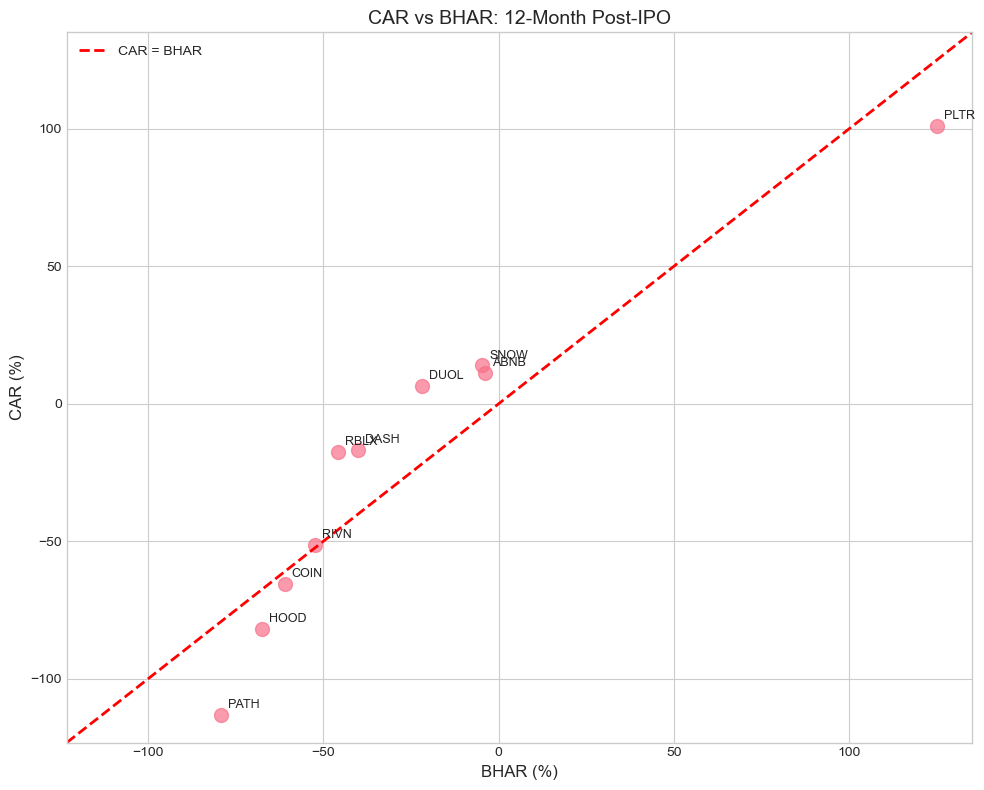


Correlation between CAR and BHAR: 0.929


In [19]:
# Visualize CAR vs BHAR
fig, ax = plt.subplots(figsize=(10, 8))

cars = [d['car']*100 for d in car_bhar_diff]
bhars = [d['bhar']*100 for d in car_bhar_diff]
tickers = [d['ticker'] for d in car_bhar_diff]

ax.scatter(bhars, cars, s=100, alpha=0.7)

# Label points
for i, ticker in enumerate(tickers):
    ax.annotate(ticker, (bhars[i], cars[i]), fontsize=9, 
                xytext=(5, 5), textcoords='offset points')

# 45-degree line
lims = [min(min(cars), min(bhars)) - 10, max(max(cars), max(bhars)) + 10]
ax.plot(lims, lims, 'r--', label='CAR = BHAR', linewidth=2)

ax.set_xlabel('BHAR (%)', fontsize=12)
ax.set_ylabel('CAR (%)', fontsize=12)
ax.set_title('CAR vs BHAR: 12-Month Post-IPO', fontsize=14)
ax.legend()
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.tight_layout()
plt.show()

# Correlation
corr = np.corrcoef(cars, bhars)[0, 1]
print(f"\nCorrelation between CAR and BHAR: {corr:.3f}")

## 5. Benchmark Selection

### Why Benchmark Choice Matters

Over long horizons, small differences in expected returns compound:
- 0.5% monthly difference × 12 months ≈ 6% annual difference!

### Common Benchmarks

1. **Market return**: Simple but ignores size/value effects
2. **Size-matched portfolio**: Match on market cap
3. **Size and B/M matched**: Two-way matching
4. **Characteristic-matched firm**: Single control firm
5. **Factor models**: Fama-French 3/5 factors

In [24]:
def download_benchmark_data(start_date: str, end_date: str) -> pd.DataFrame:
    """Download various benchmark returns."""
    tickers = {
        'market': '^GSPC',      # S&P 500
        'nasdaq': '^IXIC',      # NASDAQ (tech-heavy)
        'russell': '^RUT',      # Russell 2000 (small cap)
        'growth': 'VUG',        # Vanguard Growth ETF
    }
    
    data = {}
    for name, ticker in tickers.items():
        try:
            prices = yf.download(ticker, start=start_date, end=end_date, progress=False)['Close']
            data[name] = prices.squeeze().pct_change()
        except:
            pass
    
    return pd.DataFrame(data).dropna()


# Download benchmark data
print("Downloading benchmark data...")
benchmark_data = download_benchmark_data('2020-09-01', '2023-01-01')
print(f"Downloaded {len(benchmark_data)} days of benchmark data")

Downloaded 587 days of benchmark data


In [26]:
def calculate_bhar_with_benchmark(event_result: LongHorizonResult, 
                                   benchmark_returns: pd.Series,
                                   end_day: int = 252) -> float:
    """Calculate BHAR using a specific benchmark."""
    # Get event dates
    event_dates = event_result.data.index[:end_day+1]
    
    # Match benchmark dates
    common_dates = event_dates.intersection(benchmark_returns.index)
    
    if len(common_dates) < 20:
        return np.nan
    
    stock_rets = event_result.data.loc[common_dates, 'stock_ret']
    bench_rets = benchmark_returns.loc[common_dates]
    
    bhr_stock = (1 + stock_rets).prod() - 1
    bhr_bench = (1 + bench_rets).prod() - 1
    
    return bhr_stock - bhr_bench


# Calculate BHAR with different benchmarks
print("\nBHAR Sensitivity to Benchmark Choice (12-month horizon):")
print("="*90)

benchmark_names = ['market', 'nasdaq', 'russell', 'growth']
bhar_by_benchmark = {name: [] for name in benchmark_names}

for r in ipo_results:
    for bench_name in benchmark_names:
        if bench_name in benchmark_data.columns:
            bhar = calculate_bhar_with_benchmark(r, benchmark_data[bench_name], 252)
            if not np.isnan(bhar):
                bhar_by_benchmark[bench_name].append(bhar)

print(f"\n{'Benchmark':<15} {'Mean BHAR':>12} {'Median BHAR':>12} {'t-stat':>10} {'p-value':>10}")
print("-"*65)
for bench_name in benchmark_names:
    bhars = np.array(bhar_by_benchmark[bench_name])
    if len(bhars) > 2:
        t_stat, p_val = stats.ttest_1samp(bhars, 0)
        print(f"{bench_name.capitalize():<15} {np.mean(bhars)*100:>+11.2f}% {np.median(bhars)*100:>+11.2f}% "
              f"{t_stat:>10.2f} {p_val:>10.4f}")

print("\nNote: Results can vary substantially with benchmark choice!")


BHAR Sensitivity to Benchmark Choice (12-month horizon):

Benchmark          Mean BHAR  Median BHAR     t-stat    p-value
-----------------------------------------------------------------
Market               -25.15%      -42.80%      -1.36     0.2056
Nasdaq               -18.86%      -36.78%      -1.10     0.3008
Russell              -18.42%      -27.37%      -1.19     0.2653
Growth               -21.22%      -39.98%      -1.21     0.2585

Note: Results can vary substantially with benchmark choice!


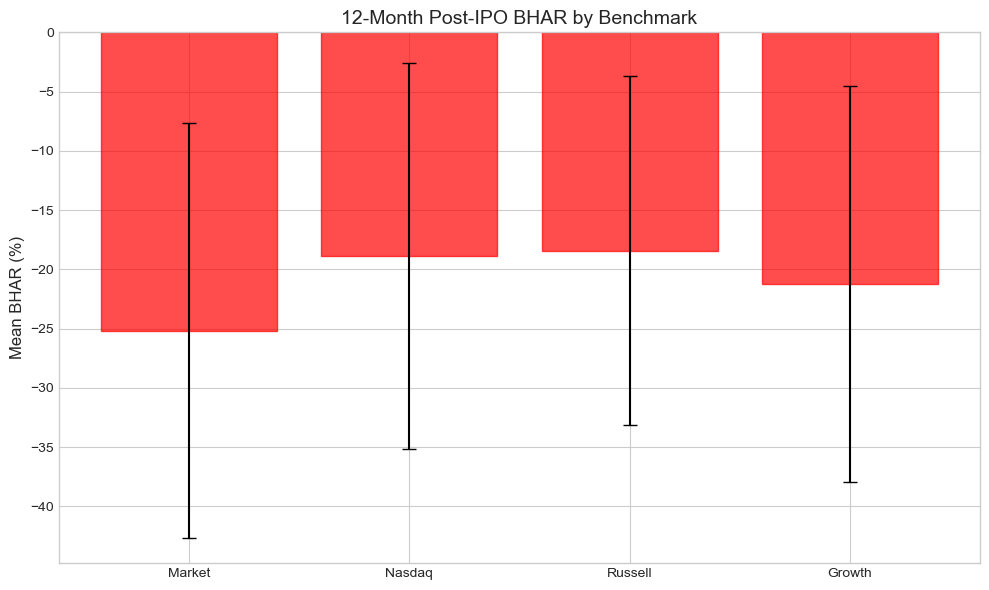

In [28]:
# Visualize benchmark sensitivity
fig, ax = plt.subplots(figsize=(10, 6))

bench_labels = [b.capitalize() for b in benchmark_names if bhar_by_benchmark[b]]
bench_means = [np.mean(bhar_by_benchmark[b])*100 for b in benchmark_names if bhar_by_benchmark[b]]
bench_stds = [np.std(bhar_by_benchmark[b])*100/np.sqrt(len(bhar_by_benchmark[b])) 
              for b in benchmark_names if bhar_by_benchmark[b]]

x = np.arange(len(bench_labels))
bars = ax.bar(x, bench_means, yerr=bench_stds, capsize=5, alpha=0.7, edgecolor='black')

# Color bars based on sign
for bar, val in zip(bars, bench_means):
    bar.set_color('green' if val > 0 else 'red')

ax.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax.set_xticks(x)
ax.set_xticklabels(bench_labels)
ax.set_ylabel('Mean BHAR (%)', fontsize=12)
ax.set_title('12-Month Post-IPO BHAR by Benchmark', fontsize=14)

plt.tight_layout()
plt.show()

## 6. Calendar-Time Portfolio Approach

### The Problem with BHAR

BHAR treats each event as independent, but:
- Events cluster in time (many IPOs in hot markets)
- This creates cross-correlation in abnormal returns
- Standard errors are understated → over-rejection

### Calendar-Time Solution

1. Each calendar month, form a portfolio of all firms within the event window
2. Calculate portfolio excess return vs benchmark
3. Run time-series regression:

$$R_{p,t} - R_{f,t} = \alpha + \beta(R_{m,t} - R_{f,t}) + \epsilon_t$$

- $\alpha$ = average monthly abnormal return
- Automatically accounts for cross-correlation

In [32]:
def create_calendar_time_portfolio(event_results: List[LongHorizonResult],
                                    horizon_months: int = 12,
                                    weighting: str = 'equal') -> pd.DataFrame:
    """
    Create calendar-time portfolio of event firms.
    
    Args:
        event_results: List of event study results
        horizon_months: How long to hold each firm after event
        weighting: 'equal' or 'value' weighted
    
    Returns:
        DataFrame with monthly portfolio returns
    """
    # Collect all daily returns with event membership
    all_returns = []
    
    for r in event_results:
        event_start = r.ipo_date
        event_end = event_start + relativedelta(months=horizon_months)
        
        for date, row in r.data.iterrows():
            if event_start <= date <= event_end:
                all_returns.append({
                    'date': date,
                    'ticker': r.ticker,
                    'stock_ret': row['stock_ret'],
                    'market_ret': row['market_ret']
                })
    
    df = pd.DataFrame(all_returns)
    
    # Convert to monthly
    df['year_month'] = df['date'].dt.to_period('M')
    
    # Calculate monthly returns for each stock
    monthly_stock = df.groupby(['year_month', 'ticker']).apply(
        lambda x: (1 + x['stock_ret']).prod() - 1
    ).reset_index(name='monthly_ret')
    
    # Calculate portfolio return (equal-weighted)
    portfolio = monthly_stock.groupby('year_month').agg({
        'monthly_ret': 'mean',
        'ticker': 'count'
    }).rename(columns={'monthly_ret': 'portfolio_ret', 'ticker': 'n_stocks'})
    
    # Get market returns
    market_monthly = df.groupby('year_month').apply(
        lambda x: (1 + x['market_ret']).prod() - 1
    )
    portfolio['market_ret'] = market_monthly
    
    # Excess return
    portfolio['excess_ret'] = portfolio['portfolio_ret'] - portfolio['market_ret']
    
    portfolio = portfolio.reset_index()
    portfolio['date'] = portfolio['year_month'].dt.to_timestamp()
    
    return portfolio


# Create calendar-time portfolio
ct_portfolio = create_calendar_time_portfolio(ipo_results, horizon_months=12)
print("Calendar-Time Portfolio:")
print("="*70)
print(ct_portfolio[['year_month', 'n_stocks', 'portfolio_ret', 'market_ret', 'excess_ret']].to_string())

Calendar-Time Portfolio:
   year_month  n_stocks  portfolio_ret  market_ret  excess_ret
0     2020-09         2      -0.005769   -0.006643    0.000874
1     2020-10         2       0.031206   -0.054566    0.085772
2     2020-11         2       0.989733    0.226657    0.763075
3     2020-12         4      -0.125000    0.126382   -0.251383
4     2021-01         4       0.266707   -0.043808    0.310515
5     2021-02         4      -0.091834    0.108522   -0.200356
6     2021-03         5      -0.104970    0.203307   -0.308277
7     2021-04         7       0.015742    0.311209   -0.295466
8     2021-05         7       0.006804    0.039043   -0.032239
9     2021-06         7       0.046184    0.166253   -0.120069
10    2021-07         9      -0.043906    0.162774   -0.206680
11    2021-08         9       0.098731    0.293308   -0.194577
12    2021-09         9      -0.000091   -0.330203    0.330112
13    2021-10         7       0.044227    0.596809   -0.552582
14    2021-11         8      -

In [34]:
# Calendar-Time Portfolio Regression (Jensen's Alpha)
print("\n" + "="*70)
print("CALENDAR-TIME PORTFOLIO REGRESSION")
print("="*70)

# Filter months with sufficient observations
ct_valid = ct_portfolio[ct_portfolio['n_stocks'] >= 2].copy()

if len(ct_valid) > 5:
    y = ct_valid['portfolio_ret']
    X = sm.add_constant(ct_valid['market_ret'])
    
    model = sm.OLS(y, X).fit()
    
    print(f"\nMonths in regression: {len(ct_valid)}")
    print(f"Average stocks per month: {ct_valid['n_stocks'].mean():.1f}")
    print("\nRegression Results:")
    print("-"*50)
    print(f"Alpha (monthly): {model.params['const']*100:+.3f}% (t={model.tvalues['const']:.2f})")
    print(f"Alpha (annual):  {((1+model.params['const'])**12-1)*100:+.2f}%")
    print(f"Beta:            {model.params['market_ret']:.3f} (t={model.tvalues['market_ret']:.2f})")
    print(f"R-squared:       {model.rsquared:.3f}")
    
    # Significance
    alpha_p = model.pvalues['const']
    sig = '***' if alpha_p < 0.01 else '**' if alpha_p < 0.05 else '*' if alpha_p < 0.10 else ''
    print(f"\nAlpha p-value: {alpha_p:.4f} {sig}")


CALENDAR-TIME PORTFOLIO REGRESSION

Months in regression: 23
Average stocks per month: 5.5

Regression Results:
--------------------------------------------------
Alpha (monthly): -0.151% (t=-0.03)
Alpha (annual):  -1.80%
Beta:            0.293 (t=1.36)
R-squared:       0.081

Alpha p-value: 0.9769 


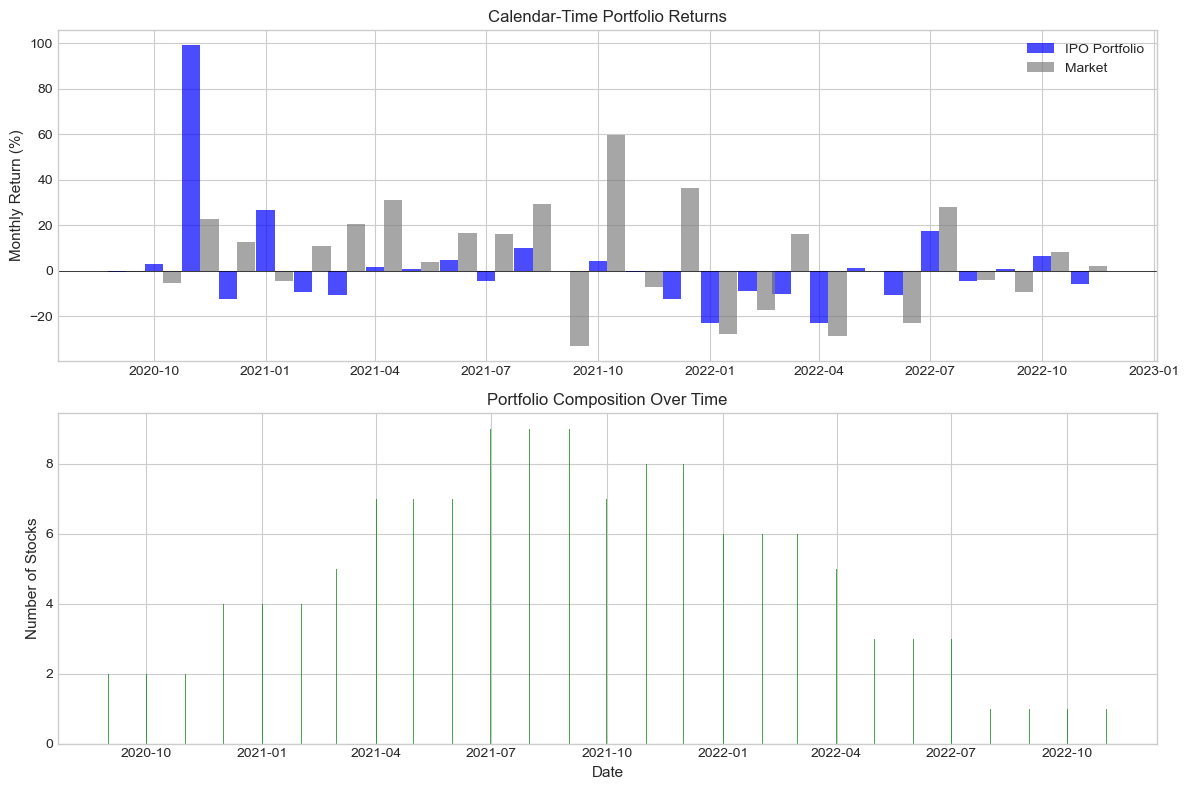

In [36]:
# Visualize calendar-time returns
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Portfolio vs Market Returns
ax1 = axes[0]
width = 15  # days for bar width
ax1.bar(ct_portfolio['date'], ct_portfolio['portfolio_ret']*100, 
        width=width, alpha=0.7, label='IPO Portfolio', color='blue')
ax1.bar(ct_portfolio['date'] + timedelta(days=width), ct_portfolio['market_ret']*100, 
        width=width, alpha=0.7, label='Market', color='gray')
ax1.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax1.set_ylabel('Monthly Return (%)', fontsize=11)
ax1.set_title('Calendar-Time Portfolio Returns', fontsize=12)
ax1.legend()

# Number of stocks over time
ax2 = axes[1]
ax2.bar(ct_portfolio['date'], ct_portfolio['n_stocks'], alpha=0.7, color='green')
ax2.set_ylabel('Number of Stocks', fontsize=11)
ax2.set_xlabel('Date', fontsize=11)
ax2.set_title('Portfolio Composition Over Time', fontsize=12)

plt.tight_layout()
plt.show()

## 7. Handling Overlapping Events

### The Problem

When event windows overlap in calendar time:
- Cross-sectional dependence in abnormal returns
- Standard errors are biased downward
- t-statistics are inflated

### Solutions

1. **Calendar-time portfolio** (Section 6): Automatically handles overlap
2. **Crude dependence adjustment**: Reduce effective N
3. **Clustering adjustment**: Cluster standard errors by time

In [38]:
def analyze_event_clustering(event_results: List[LongHorizonResult],
                              horizon_months: int = 12) -> Dict:
    """
    Analyze the degree of event clustering/overlap.
    """
    # Create event timeline
    events = []
    for r in event_results:
        start = r.ipo_date
        end = start + relativedelta(months=horizon_months)
        events.append({'ticker': r.ticker, 'start': start, 'end': end})
    
    events_df = pd.DataFrame(events)
    
    # Calculate overlap matrix
    n = len(events)
    overlap_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            if i != j:
                # Check if windows overlap
                start_i, end_i = events[i]['start'], events[i]['end']
                start_j, end_j = events[j]['start'], events[j]['end']
                
                overlap_start = max(start_i, start_j)
                overlap_end = min(end_i, end_j)
                
                if overlap_start < overlap_end:
                    # Calculate overlap proportion
                    window_length_i = (end_i - start_i).days
                    overlap_days = (overlap_end - overlap_start).days
                    overlap_matrix[i, j] = overlap_days / window_length_i
    
    # Summary statistics
    avg_overlap = np.mean(overlap_matrix[overlap_matrix > 0]) if np.sum(overlap_matrix > 0) > 0 else 0
    n_overlapping_pairs = np.sum(overlap_matrix > 0) / 2  # Divide by 2 for symmetric
    
    return {
        'n_events': n,
        'n_overlapping_pairs': int(n_overlapping_pairs),
        'avg_overlap': avg_overlap,
        'overlap_matrix': overlap_matrix,
        'events_df': events_df
    }


# Analyze clustering
clustering = analyze_event_clustering(ipo_results, horizon_months=12)

print("Event Clustering Analysis:")
print("="*60)
print(f"Total events: {clustering['n_events']}")
print(f"Overlapping pairs: {clustering['n_overlapping_pairs']}")
print(f"Average overlap (when overlapping): {clustering['avg_overlap']*100:.1f}%")
print(f"\nThis clustering can inflate t-statistics in BHAR tests!")

Event Clustering Analysis:
Total events: 10
Overlapping pairs: 43
Average overlap (when overlapping): 57.6%

This clustering can inflate t-statistics in BHAR tests!


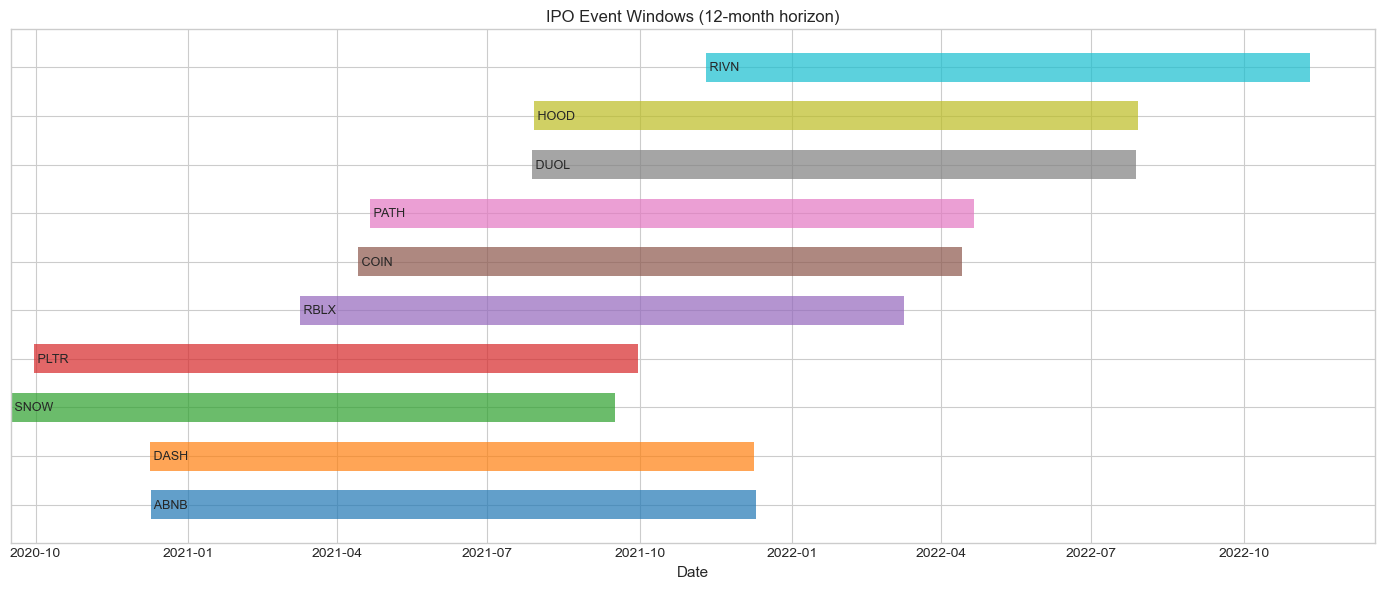

In [40]:
# Visualize event timeline
fig, ax = plt.subplots(figsize=(14, 6))

events_df = clustering['events_df']
colors = plt.cm.tab10(np.linspace(0, 1, len(events_df)))

for i, (_, row) in enumerate(events_df.iterrows()):
    ax.barh(i, (row['end'] - row['start']).days, left=row['start'], 
            height=0.6, alpha=0.7, color=colors[i], label=row['ticker'])
    ax.text(row['start'], i, f" {row['ticker']}", va='center', fontsize=9)

ax.set_yticks(range(len(events_df)))
ax.set_yticklabels(['' for _ in range(len(events_df))])
ax.set_xlabel('Date', fontsize=11)
ax.set_title('IPO Event Windows (12-month horizon)', fontsize=12)

plt.tight_layout()
plt.show()

In [42]:
# Crude dependence adjustment
def crude_dependence_adjustment(bhars: np.ndarray, avg_overlap: float) -> Dict:
    """
    Adjust t-statistic for cross-sectional dependence.
    
    Following Kolari-Pynnönen (2010) style adjustment.
    """
    N = len(bhars)
    mean_bhar = np.mean(bhars)
    std_bhar = np.std(bhars, ddof=1)
    
    # Unadjusted t-statistic
    t_unadj = mean_bhar / (std_bhar / np.sqrt(N))
    p_unadj = 2 * (1 - stats.t.cdf(abs(t_unadj), df=N-1))
    
    # Adjusted: assume correlation proportional to overlap
    # Effective N reduction
    avg_corr = avg_overlap * 0.5  # Rough approximation
    adjustment_factor = np.sqrt((1 - avg_corr) / (1 + (N-1) * avg_corr))
    
    t_adj = t_unadj * adjustment_factor
    p_adj = 2 * (1 - stats.t.cdf(abs(t_adj), df=N-1))
    
    return {
        'N': N,
        'mean_bhar': mean_bhar,
        't_unadjusted': t_unadj,
        'p_unadjusted': p_unadj,
        't_adjusted': t_adj,
        'p_adjusted': p_adj,
        'adjustment_factor': adjustment_factor
    }


# Apply adjustment
bhars_12m = np.array([r.bhar for r in ipo_results])
adj_results = crude_dependence_adjustment(bhars_12m, clustering['avg_overlap'])

print("\nCrude Dependence Adjustment:")
print("="*60)
print(f"Mean BHAR: {adj_results['mean_bhar']*100:+.2f}%")
print(f"\nUnadjusted t-stat: {adj_results['t_unadjusted']:.3f} (p={adj_results['p_unadjusted']:.4f})")
print(f"Adjusted t-stat:   {adj_results['t_adjusted']:.3f} (p={adj_results['p_adjusted']:.4f})")
print(f"\nAdjustment factor: {adj_results['adjustment_factor']:.3f}")


Crude Dependence Adjustment:
Mean BHAR: -25.57%

Unadjusted t-stat: -1.377 (p=0.2017)
Adjusted t-stat:   -0.613 (p=0.5549)

Adjustment factor: 0.445


## 8. Statistical Inference for Long-Horizon Studies

### The Bad News: Low Power

Long-horizon tests have notoriously low power:
- High variance in long-run returns
- Model misspecification compounds
- Need very large samples

### Testing Approaches

1. **Cross-sectional t-test on BHAR** (problematic)
2. **Bootstrapped confidence intervals**
3. **Calendar-time alpha** (preferred)
4. **Skewness-adjusted tests**

In [44]:
def bootstrap_bhar_test(bhars: np.ndarray, n_boot: int = 5000) -> Dict:
    """
    Bootstrap test for BHAR.
    """
    N = len(bhars)
    observed_mean = np.mean(bhars)
    
    np.random.seed(42)
    boot_means = [np.mean(np.random.choice(bhars, N, replace=True)) for _ in range(n_boot)]
    boot_means = np.array(boot_means)
    
    # Confidence intervals
    ci_90 = np.percentile(boot_means, [5, 95])
    ci_95 = np.percentile(boot_means, [2.5, 97.5])
    ci_99 = np.percentile(boot_means, [0.5, 99.5])
    
    # p-value
    p_value = np.mean(np.abs(boot_means - observed_mean) >= np.abs(observed_mean))
    
    return {
        'mean': observed_mean,
        'boot_se': np.std(boot_means),
        'ci_90': ci_90,
        'ci_95': ci_95,
        'ci_99': ci_99,
        'p_value': p_value,
        'boot_distribution': boot_means
    }


# Bootstrap test
boot_results = bootstrap_bhar_test(bhars_12m, n_boot=5000)

print("Bootstrap Inference for 12-Month BHAR:")
print("="*60)
print(f"Mean BHAR: {boot_results['mean']*100:+.2f}%")
print(f"Bootstrap SE: {boot_results['boot_se']*100:.2f}%")
print(f"\n90% CI: [{boot_results['ci_90'][0]*100:+.2f}%, {boot_results['ci_90'][1]*100:+.2f}%]")
print(f"95% CI: [{boot_results['ci_95'][0]*100:+.2f}%, {boot_results['ci_95'][1]*100:+.2f}%]")
print(f"99% CI: [{boot_results['ci_99'][0]*100:+.2f}%, {boot_results['ci_99'][1]*100:+.2f}%]")
print(f"\np-value: {boot_results['p_value']:.4f}")

Bootstrap Inference for 12-Month BHAR:
Mean BHAR: -25.57%
Bootstrap SE: 17.40%

90% CI: [-50.78%, +6.11%]
95% CI: [-54.23%, +11.70%]
99% CI: [-58.91%, +27.29%]

p-value: 0.1320


In [46]:
# Skewness-adjusted test (Lyon, Barber, Tsai 1999)
def skewness_adjusted_t_test(bhars: np.ndarray) -> Dict:
    """
    Skewness-adjusted t-statistic following Lyon, Barber, Tsai (1999).
    """
    N = len(bhars)
    mean_bhar = np.mean(bhars)
    std_bhar = np.std(bhars, ddof=1)
    skew = stats.skew(bhars)
    
    # Standard t-stat
    t_standard = mean_bhar / (std_bhar / np.sqrt(N))
    
    # Skewness adjustment
    # t_sa = sqrt(N) * (S + (1/3)*gamma*S^2 + (1/6N)*gamma)
    # where S = mean/std, gamma = skewness
    S = mean_bhar / std_bhar
    t_sa = np.sqrt(N) * (S + (1/3) * skew * S**2 + (1/(6*N)) * skew)
    
    p_standard = 2 * (1 - stats.t.cdf(abs(t_standard), df=N-1))
    p_adjusted = 2 * (1 - stats.norm.cdf(abs(t_sa)))
    
    return {
        'N': N,
        'mean': mean_bhar,
        'skewness': skew,
        't_standard': t_standard,
        'p_standard': p_standard,
        't_skew_adj': t_sa,
        'p_skew_adj': p_adjusted
    }


skew_results = skewness_adjusted_t_test(bhars_12m)

print("\nSkewness-Adjusted t-Test (Lyon, Barber, Tsai 1999):")
print("="*60)
print(f"Sample skewness: {skew_results['skewness']:.3f}")
print(f"\nStandard t-stat:     {skew_results['t_standard']:.3f} (p={skew_results['p_standard']:.4f})")
print(f"Skew-adjusted t-stat: {skew_results['t_skew_adj']:.3f} (p={skew_results['p_skew_adj']:.4f})")


Skewness-Adjusted t-Test (Lyon, Barber, Tsai 1999):
Sample skewness: 1.806

Standard t-stat:     -1.377 (p=0.2017)
Skew-adjusted t-stat: -0.921 (p=0.3571)


## 9. Comprehensive Results Comparison

In [48]:
# Summary table of all approaches
print("\n" + "="*90)
print("COMPREHENSIVE RESULTS: 12-Month Post-IPO Performance")
print("="*90)

print(f"\nSample: {len(ipo_results)} tech IPOs (2020-2021)")
print(f"Mean BHAR: {np.mean(bhars_12m)*100:+.2f}%")
print(f"Median BHAR: {np.median(bhars_12m)*100:+.2f}%")

print("\n" + "-"*90)
print(f"{'Method':<35} {'Statistic':>15} {'p-value':>12} {'Conclusion':>20}")
print("-"*90)

# Standard t-test
t_stat, p_val = stats.ttest_1samp(bhars_12m, 0)
conclusion = 'Significant*' if p_val < 0.10 else 'Not significant'
print(f"{'Standard t-test (BHAR)':<35} {t_stat:>15.3f} {p_val:>12.4f} {conclusion:>20}")

# Dependence-adjusted
conclusion = 'Significant*' if adj_results['p_adjusted'] < 0.10 else 'Not significant'
print(f"{'Dependence-adjusted t-test':<35} {adj_results['t_adjusted']:>15.3f} "
      f"{adj_results['p_adjusted']:>12.4f} {conclusion:>20}")

# Skewness-adjusted
conclusion = 'Significant*' if skew_results['p_skew_adj'] < 0.10 else 'Not significant'
print(f"{'Skewness-adjusted t-test':<35} {skew_results['t_skew_adj']:>15.3f} "
      f"{skew_results['p_skew_adj']:>12.4f} {conclusion:>20}")

# Bootstrap
conclusion = 'Significant*' if boot_results['p_value'] < 0.10 else 'Not significant'
print(f"{'Bootstrap test':<35} {'N/A':>15} {boot_results['p_value']:>12.4f} {conclusion:>20}")

# Calendar-time alpha
if len(ct_valid) > 5:
    alpha_annual = ((1 + model.params['const'])**12 - 1)
    conclusion = 'Significant*' if model.pvalues['const'] < 0.10 else 'Not significant'
    print(f"{'Calendar-time alpha (annual)':<35} {alpha_annual*100:>14.2f}% "
          f"{model.pvalues['const']:>12.4f} {conclusion:>20}")

print("-"*90)
print("* Significant at 10% level")


COMPREHENSIVE RESULTS: 12-Month Post-IPO Performance

Sample: 10 tech IPOs (2020-2021)
Mean BHAR: -25.57%
Median BHAR: -44.84%

------------------------------------------------------------------------------------------
Method                                    Statistic      p-value           Conclusion
------------------------------------------------------------------------------------------
Standard t-test (BHAR)                       -1.377       0.2017      Not significant
Dependence-adjusted t-test                   -0.613       0.5549      Not significant
Skewness-adjusted t-test                     -0.921       0.3571      Not significant
Bootstrap test                                  N/A       0.1320      Not significant
Calendar-time alpha (annual)                 -1.80%       0.9769      Not significant
------------------------------------------------------------------------------------------
* Significant at 10% level


## 10. Best Practices and Recommendations

### Reporting Guidelines

1. **Report multiple measures**: BHAR, CAR, and calendar-time alpha
2. **Test multiple benchmarks**: Show sensitivity
3. **Acknowledge clustering**: Report adjusted statistics
4. **Graph cumulative returns**: Visual inspection is informative
5. **Report medians**: BHAR is often skewed

### Common Pitfalls

| Pitfall | Solution |
|---------|----------|
| Using only BHAR t-test | Report calendar-time alpha |
| Single benchmark | Test multiple benchmarks |
| Ignoring clustering | Use dependence adjustment |
| Small sample confidence | Bootstrap or be cautious |
| Survivorship bias | Address delistings |

In [50]:
# Publication-ready table
print("\n" + "="*90)
print("TABLE: Long-Horizon Post-IPO Performance")
print("="*90)

print("\nPanel A: Buy-and-Hold Abnormal Returns (BHAR)")
print("-"*70)
print(f"{'Horizon':<15} {'N':>6} {'Mean':>10} {'Median':>10} {'t-stat':>10} {'% Neg':>10}")
print("-"*70)

for (start, end, label) in horizons:
    if label in bhar_results:
        bhars = bhar_results[label]
        t, p = stats.ttest_1samp(bhars, 0)
        sig = '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.10 else ''
        pct_neg = np.mean(bhars < 0) * 100
        print(f"{label:<15} {len(bhars):>6} {np.mean(bhars)*100:>+9.2f}% {np.median(bhars)*100:>+9.2f}% "
              f"{t:>8.2f}{sig:<2} {pct_neg:>9.0f}%")

print("-"*70)
print("***, **, * indicate significance at 1%, 5%, 10% levels")

if len(ct_valid) > 5:
    print("\nPanel B: Calendar-Time Portfolio Regression")
    print("-"*70)
    print(f"Monthly alpha: {model.params['const']*100:+.3f}% (t={model.tvalues['const']:.2f})")
    print(f"Annual alpha:  {((1+model.params['const'])**12-1)*100:+.2f}%")
    print(f"Market beta:   {model.params['market_ret']:.3f}")
    print(f"Months: {len(ct_valid)}, Avg stocks/month: {ct_valid['n_stocks'].mean():.1f}")


TABLE: Long-Horizon Post-IPO Performance

Panel A: Buy-and-Hold Abnormal Returns (BHAR)
----------------------------------------------------------------------
Horizon              N       Mean     Median     t-stat      % Neg
----------------------------------------------------------------------
1 month             10     +1.98%     +2.47%     0.39          50%
3 months            10    +15.36%     +9.53%     0.87          50%
6 months            10    -16.81%    -30.37%    -1.00          80%
12 months           10    -25.14%    -42.98%    -1.36          90%
----------------------------------------------------------------------
***, **, * indicate significance at 1%, 5%, 10% levels

Panel B: Calendar-Time Portfolio Regression
----------------------------------------------------------------------
Monthly alpha: -0.151% (t=-0.03)
Annual alpha:  -1.80%
Market beta:   0.293
Months: 23, Avg stocks/month: 5.5


## 11. Exercises

### Exercise 1: Fama-French Adjustment
Download Fama-French factors and estimate calendar-time alpha controlling for SMB and HML.

### Exercise 2: Size Portfolios
Create size-matched benchmarks using market cap at IPO.

### Exercise 3: Subsample Analysis
Split the sample by IPO year and test for differences.

In [52]:
# Exercise 3: Subsample by IPO year
print("Exercise 3: BHAR by IPO Year")
print("="*60)

for year in [2020, 2021]:
    year_results = [r for r in ipo_results if r.ipo_date.year == year]
    if year_results:
        bhars_year = np.array([r.bhar for r in year_results])
        t, p = stats.ttest_1samp(bhars_year, 0) if len(bhars_year) > 1 else (np.nan, np.nan)
        print(f"\n{year} IPOs (n={len(year_results)}):")
        print(f"  Mean BHAR: {np.mean(bhars_year)*100:+.2f}%")
        print(f"  Median BHAR: {np.median(bhars_year)*100:+.2f}%")
        if not np.isnan(t):
            print(f"  t-stat: {t:.2f} (p={p:.4f})")

Exercise 3: BHAR by IPO Year

2020 IPOs (n=4):
  Mean BHAR: +19.09%
  Median BHAR: -4.26%
  t-stat: 0.53 (p=0.6353)

2021 IPOs (n=6):
  Mean BHAR: -55.34%
  Median BHAR: -57.03%
  t-stat: -6.92 (p=0.0010)


## 12. Summary

### Key Takeaways

1. **BHAR vs CAR**: Use BHAR for long horizons (accounts for compounding)

2. **Benchmark sensitivity**: Results can change dramatically with benchmark choice

3. **Calendar-time approach**: Preferred for handling cross-correlation

4. **Event clustering**: Adjust standard errors or use calendar-time

5. **Low power**: Be cautious with small samples and non-significant results

6. **Multiple tests**: Report various methods for robustness

### When to Use Long-Horizon Studies

- Testing market efficiency (does initial reaction persist?)
- Long-term value creation (M&A, restructuring)
- Investment strategy evaluation (IPO underperformance)

### Coming Up Next

**Session 8: Extensions and Special Topics**

## References

- Barber, B. M., & Lyon, J. D. (1997). Detecting long-run abnormal stock returns: The empirical power and specification of test statistics. *Journal of Financial Economics*, 43(3), 341-372.
- Fama, E. F. (1998). Market efficiency, long-term returns, and behavioral finance. *Journal of Financial Economics*, 49(3), 283-306.
- Lyon, J. D., Barber, B. M., & Tsai, C. L. (1999). Improved methods for tests of long-run abnormal stock returns. *Journal of Finance*, 54(1), 165-201.
- Mitchell, M. L., & Stafford, E. (2000). Managerial decisions and long-term stock price performance. *Journal of Business*, 73(3), 287-329.